# Data Overview

### Imports

In [1]:
import os
import sys
import gc
from pathlib import Path
from typing import List
from dotenv import load_dotenv

import pandas as pd
import polars as pl
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

try:
    from src.logging_setup import setup_logging
    from src.data_preprocessing import load_and_encode_data, preprocess_data
    from src.feature_engineering import engineer_features
    from src.train_test_split import temporal_train_test_split, load_splits
except ImportError:
    PROJECT_ROOT = Path.cwd().parent
    if str(PROJECT_ROOT) not in sys.path:
        sys.path.insert(0, str(PROJECT_ROOT))
    from src.logging_setup import setup_logging
    from src.data_preprocessing import load_and_encode_data, preprocess_data
    from src.feature_engineering import engineer_features
    from src.train_test_split import temporal_train_test_split, load_splits

[2026-01-05 21:07:05,581] [INFO] Logging to C:\Users\iulii\final_project\logs\logs_data_preprocessing.json setup completed
[2026-01-05 21:07:05,581] [INFO] Logging to C:\Users\iulii\final_project\logs\logs_feature_engineering.json setup completed
[2026-01-05 21:07:05,587] [INFO] Logging to C:\Users\iulii\final_project\logs\logs_train_test_split.json setup completed


### Config

In [2]:
# Set working directory to project root (use cwd().parent for notebooks in notebooks/ folder)
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name == 'notebooks' else Path.cwd()
os.chdir(PROJECT_ROOT)

In [3]:
logger = setup_logging('project_notebook')

[2026-01-05 21:07:05,607] [INFO] Logging to C:\Users\iulii\final_project\logs\logs_project_notebook.json setup completed


In [4]:
# Load environment variables
load_dotenv()

True

In [5]:
# Constants
# Data directory
DATA_DIR = os.getenv('DATA_DIR', './data')
# Results directory
RESULTS_DIR = os.getenv('RESULTS_DIR', './results')
# Raw data file
RAW_DATA_FILE = os.getenv('RAW_DATA_FILE', 'train_ver2.csv')
# Preprocessed data file
PREPROCESSED_DATA_FILE = os.getenv('PREPROCESSED_DATA_FILE', 'data_preprocessed.parquet')


In [6]:
# Create directories if they don't exist
os.makedirs(DATA_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

### Helper functions

In [7]:
# Data summary helper function
def data_summary(
    df: pl.DataFrame, 
    name: str,
    results_dir: str = RESULTS_DIR
):
    '''
        Display a quick overview of a Polars DataFrame.
    '''
    print(f'\n===== {name.upper()} =====')

    # Sample rows
    print('\nSample rows:')
    display(df.head())

    # Shape
    rows, cols = df.shape
    print(f'\nShape: {rows} rows x {cols} columns')

    # Data types
    print('\nData types:')
    for col, dt in zip(df.columns, df.dtypes):
        print(f'{col}: {dt}')

    # Numeric columns
    print('\nSummary for numeric columns:')
    numeric_types = (pl.Int8, pl.Int16, pl.Int32, pl.Int64,
                     pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
                     pl.Float32, pl.Float64)
    numeric_cols = [c for c, dt in zip(df.columns, df.dtypes)
                    if isinstance(dt, numeric_types)]
    if numeric_cols:
        summary_name = f"{name}_numeric_summary"
        globals()[summary_name] = df.select(numeric_cols).describe()
        display(globals()[summary_name])
        globals()[summary_name].write_parquet(f'{results_dir}/{summary_name}.parquet')
    else:
        print('No numeric columns')

    # Unique values
    print(f'\nUnique customer id values: {df["ncodpers"].n_unique()}')
    print('Unique values:')
    cat_like_types = (pl.Categorical, pl.Boolean, pl.Date)
    cat_like_cols = [c for c, dt in zip(df.columns, df.dtypes)
                     if isinstance(dt, cat_like_types)]
    for col in cat_like_cols:
        print(f'\nColumn: {col}')
        display(df.select(pl.col(col).value_counts()))

    # Missing values
    print('\nMissing values:')
    display(df.null_count())

In [8]:
# Plot correlation heatmap helper function
def plot_correlation_heatmap(
    df: pl.DataFrame,
    results_dir: str = RESULTS_DIR
):
    '''
        Plot correlation heatmap for numeric and boolean columns in a Polars DataFrame.
        Returns the correlation matrix and displays top 10 strongest correlations.
    '''
    
    # Identify numeric and boolean columns
    numeric_types = (pl.Int8, pl.Int16, pl.Int32, pl.Int64,
                     pl.UInt8, pl.UInt16, pl.UInt32, pl.UInt64,
                     pl.Float32, pl.Float64)
    numeric_cols = [c for c, dt in zip(df.columns, df.dtypes)
                    if isinstance(dt, numeric_types)]
    boolean_cols = [c for c, dt in zip(df.columns, df.dtypes)
                    if isinstance(dt, pl.Boolean)]
    
    all_cols = numeric_cols + boolean_cols
    print(f'Selected {len(numeric_cols)} numeric and {len(boolean_cols)} boolean columns')

    # Cast all columns to Float64 for correlation computation
    df_casted = df.select(
        [pl.col(c).cast(pl.Float64) for c in all_cols]
    )
    
    # Check for nulls before filling
    null_counts = df_casted.null_count()
    cols_with_nulls = [col for col in all_cols if null_counts[col][0] > 0]
    if cols_with_nulls:
        print(f'Columns with null values: {cols_with_nulls}')
        print('Filling nulls with column means for correlation computation')
    
    # Fill nulls with column means to enable correlation computation
    df_filled = df_casted.select(
        [pl.col(c).fill_null(pl.col(c).mean()) for c in all_cols]
    )

    # Compute correlation matrix using Polars (returns a DataFrame)
    corr_df = df_filled.corr()
    
    # Convert to numpy for plotting (Polars corr() returns DataFrame with column names as first col)
    corr_matrix = corr_df.to_numpy()
    
    print(f'Correlation matrix shape: {corr_matrix.shape}')

    # Create heatmap plot
    plt.figure(figsize=(20, 20))
    sns.heatmap(
        corr_matrix, 
        annot=True, 
        cmap='coolwarm', 
        linewidths=0.5, 
        center=0,
        xticklabels=all_cols,
        yticklabels=all_cols,
        fmt='.2f'
    )
    plt.title('Correlation Map of Features')
    plt.tight_layout()
    
    plt.savefig(f'{results_dir}/correlation_heatmap.png', dpi=150, bbox_inches='tight')
    print(f'Correlation heatmap saved to: {results_dir}/correlation_heatmap.png')
    
    plt.show()

    # Find top 10 strongest correlations (excluding self-correlations)
    correlations = []
    n = len(all_cols)
    for i in range(n):
        for j in range(i + 1, n):  # Upper triangle only
            correlations.append({
                'feature_1': all_cols[i],
                'feature_2': all_cols[j],
                'correlation': corr_matrix[i, j]
            })
    
    # Create Polars DataFrame and sort by absolute correlation
    top_corrs = (
        pl.DataFrame(correlations)
        .with_columns(pl.col('correlation').abs().alias('abs_correlation'))
        .sort('abs_correlation', descending=True)
        .head(10)
        .drop('abs_correlation')
    )
    
    print('\nTop 10 strongest correlations:')
    display(top_corrs)

    return corr_df, top_corrs

### Raw Data Overview

In [9]:
# Load raw data
df = pl.read_csv(
    f"{DATA_DIR}/{RAW_DATA_FILE}", 
    infer_schema_length=10000,
    null_values=['NA', 'N/A', 'NaN', 'nan', 'null', 'None', '', ' '],
    ignore_errors=True # Load data even if some rows are corrupted
)

In [10]:
# Data overview
print('Data overview')
raw_data_summary = df.describe()
display(raw_data_summary)
raw_data_summary.write_parquet(f'{RESULTS_DIR}/raw_data_summary.parquet')

# Shape
rows, cols = df.shape
print(f'Shape: {rows} rows x {cols} columns')

# Data types
print('Data types:')
display(df.dtypes)
  
# Unique values (top 10 per column)
print('Unique values:')
for col in df.columns:
    print(f'Column: {col}')
    display(df[col].value_counts().head(10))

# Missing values
print('Missing values:')
display(df.null_count())

Data overview


statistic,fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
str,str,f64,str,str,str,str,str,str,str,str,str,f64,str,str,str,str,str,str,str,str,str,str,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,str,str,f64
"""count""","""13647309""",1.3647309e7,"""13619575""","""13619575""","""13619505""","""13647309""","""13619575""","""13619575""","""13647309""","""13619575""","""24793""",1.3496654e7,"""13497528""","""13619575""","""13619575""","""1808""","""13461183""","""13619575""","""13619574""","""13553718""","""13553718""","""13619575""",1.0852934e7,"""13457941""",1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,1.3647309e7,"""13631246""","""13631246""",1.3647309e7
"""null_count""","""0""",0.0,"""27734""","""27734""","""27804""","""0""","""27734""","""27734""","""0""","""27734""","""13622516""",150655.0,"""149781""","""27734""","""27734""","""13645501""","""186126""","""27734""","""27735""","""93591""","""93591""","""27734""",2.794375e6,"""189368""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,"""16063""","""16063""",0.0
"""mean""",null,834904.211501,null,null,null,null,null,null,null,null,null,1.00081,null,null,null,null,null,null,null,null,null,null,134254.318238,null,0.000102,0.000023,0.655484,0.000394,0.080867,0.009474,0.009727,0.129008,0.043306,0.001779,0.001661,0.042967,0.082744,0.018486,0.005887,0.009171,0.002627,0.052536,0.044389,0.025608,0.003848,null,null,0.127916
"""std""",null,431565.025784,null,null,null,null,null,null,null,null,null,0.039877,null,null,null,null,null,null,null,null,null,null,230620.238822,null,0.010113,0.004812,0.47521,0.019844,0.272631,0.096873,0.098143,0.335209,0.203545,0.042138,0.040721,0.202782,0.275494,0.134701,0.076498,0.095325,0.051191,0.223106,0.205957,0.157962,0.061911,null,null,0.333996
"""min""","""2015-01-28""",15889.0,"""A""","""AD""","""H""",""" 2""","""1995-01-16""",""" 0""",""" 0""",""" 1""","""2015-07-01""",1.0,"""A""","""N""","""N""","""N""","""004""","""N""",""" 1""",""" 1""","""ALAVA""",""" 0""",1202.73,"""01 - TOP""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,""" 0""",""" 0""",0.0
"""25%""",null,452813.0,null,null,null,null,null,null,null,null,null,1.0,null,null,null,null,null,null,null,null,null,null,68710.98,null,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,0.0
"""50%""",null,931893.0,null,null,null,null,null,null,null,null,null,1.0,null,null,null,null,null,null,null,null,null,null,101850.0,null,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,0.0
"""75%""",null,1.199286e6,null,null,null,null,null,null,null,null,null,1.0,null,null,null,null,null,null,null,null,null,null,155955.96,null,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,null,null,0.0
"""max""","""2016-05-28""",1.553689e6,"""S""","""ZW""","""V""","""164""","""2016-05-31""",""" 1""","""-999999""","""99""","""2016-05-30""",4.0,"""R""","""S""","""S""","""S""","""RED""","""S""",""" 1""","""52""","""ZARAGOZA""",""" 1""",2.8894e7,"""03 - UNIVERSITARIO""",1.0,1.0,1.0,1.0,1.0,1.0,1.

Shape: 13647309 rows x 48 columns
Data types:


[String,
 Int64,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 Float64,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 String,
 Float64,
 String,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 Int64,
 String,
 String,
 Int64]

Unique values:
Column: fecha_dato


fecha_dato,count
str,u32
"""2016-02-28""",920904
"""2015-03-28""",629209
"""2015-12-28""",912021
"""2015-02-28""",627394
"""2015-06-28""",632110
"""2015-09-28""",865440
"""2015-08-28""",843201
"""2015-07-28""",829817
"""2016-04-28""",928274


Column: ncodpers


ncodpers,count
i64,u32
1455005,9
1504423,7
1144832,17
494173,11
1021519,17
928197,17
974720,17
1308338,17
361571,17


Column: ind_empleado


ind_empleado,count
str,u32
"""N""",13610977
"""F""",2523
"""B""",3566
null,27734
"""S""",17
"""A""",2492


Column: pais_residencia


pais_residencia,count
str,u32
"""CD""",17
"""AR""",4835
"""CM""",85
"""GA""",51
"""EG""",68
"""FI""",345
"""CR""",147
"""PH""",34
"""SK""",85


Column: sexo


sexo,count
str,u32
"""V""",7424252
null,27804
"""H""",6195253


Column: age


age,count
str,u32
"""109""",265
""" 70""",70192
""" 22""",736314
""" 77""",49218
""" 62""",101186
""" 28""",240192
""" 45""",314771
""" 98""",4622
""" 33""",170477


Column: fecha_alta


fecha_alta,count
str,u32
"""2011-04-14""",777
"""2002-11-16""",808
"""2009-10-22""",423
"""1995-02-16""",17
"""2007-01-26""",1630
"""2010-11-03""",870
"""2011-08-22""",2703
"""2010-05-18""",1893
"""2008-03-29""",307


Column: ind_nuevo


ind_nuevo,count
str,u32
""" 0""",12808368
null,27734
""" 1""",811207


Column: antiguedad


antiguedad,count
str,u32
""" 244""",5928
""" 235""",10836
""" 250""",1512
""" 125""",44840
""" 156""",45711
""" 92""",37944
""" 14""",126798
""" 176""",44779
""" 33""",174352


Column: indrel


indrel,count
str,u32
null,27734
"""99""",24793
""" 1""",13594782


Column: ult_fec_cli_1t


ult_fec_cli_1t,count
str,u32
"""2015-11-12""",76
"""2016-02-22""",100
"""2015-07-10""",320
"""2016-05-11""",74
"""2015-08-18""",59
"""2015-10-19""",110
"""2015-09-16""",82
"""2015-11-25""",86
"""2016-05-16""",89


Column: indrel_1mes


indrel_1mes,count
f64,u32
2.0,1317
4.0,306
3.0,4350
null,150655
1.0,13490681


Column: tiprel_1mes


tiprel_1mes,count
str,u32
"""I""",7304875
"""P""",4656
null,149781
"""R""",870
"""N""",4
"""A""",6187123


Column: indresi


indresi,count
str,u32
null,27734
"""N""",65864
"""S""",13553711


Column: indext


indext,count
str,u32
"""S""",644736
"""N""",12974839
null,27734


Column: conyuemp


conyuemp,count
str,u32
"""S""",17
"""N""",1791
null,13645501


Column: canal_entrada


canal_entrada,count
str,u32
"""KHL""",45128
"""KBF""",3760
"""KFG""",6800
"""KCU""",1081
"""KAJ""",24280
"""KEC""",231
"""KAZ""",32186
"""KGW""",989
"""KAT""",3268209


Column: indfall


indfall,count
str,u32
"""S""",34762
null,27734
"""N""",13584813


Column: tipodom


tipodom,count
str,u32
null,27735
""" 1""",13619574


Column: cod_prov


cod_prov,count
str,u32
"""22""",40181
"""40""",42341
"""27""",84962
"""25""",79059
"""37""",164238
""" 9""",97188
"""19""",64618
"""10""",129912
""" 8""",1275219


Column: nomprov


nomprov,count
str,u32
"""NAVARRA""",88618
"""SORIA""",17660
"""CACERES""",129912
"""VALENCIA""",682304
null,93591
"""SEVILLA""",605164
"""LUGO""",84962
"""HUELVA""",122283
"""OURENSE""",84009


Column: ind_actividad_cliente


ind_actividad_cliente,count
str,u32
""" 1""",6235185
""" 0""",7384390
null,27734


Column: renta


renta,count
f64,u32
60678.72,17
332507.52,17
39689.7,17
96352.89,11
91086.03,11
97611.42,17
218115.03,11
51878.52,11
34510.98,11


Column: segmento


segmento,count
str,u32
"""02 - PARTICULARES""",7960220
null,189368
"""01 - TOP""",562142
"""03 - UNIVERSITARIO""",4935579


Column: ind_ahor_fin_ult1


ind_ahor_fin_ult1,count
i64,u32
1,1396
0,13645913


Column: ind_aval_fin_ult1


ind_aval_fin_ult1,count
i64,u32
0,13646993
1,316


Column: ind_cco_fin_ult1


ind_cco_fin_ult1,count
i64,u32
0,4701721
1,8945588


Column: ind_cder_fin_ult1


ind_cder_fin_ult1,count
i64,u32
1,5376
0,13641933


Column: ind_cno_fin_ult1


ind_cno_fin_ult1,count
i64,u32
1,1103620
0,12543689


Column: ind_ctju_fin_ult1


ind_ctju_fin_ult1,count
i64,u32
1,129297
0,13518012


Column: ind_ctma_fin_ult1


ind_ctma_fin_ult1,count
i64,u32
0,13514567
1,132742


Column: ind_ctop_fin_ult1


ind_ctop_fin_ult1,count
i64,u32
0,11886693
1,1760616


Column: ind_ctpp_fin_ult1


ind_ctpp_fin_ult1,count
i64,u32
1,591008
0,13056301


Column: ind_deco_fin_ult1


ind_deco_fin_ult1,count
i64,u32
1,24275
0,13623034


Column: ind_deme_fin_ult1


ind_deme_fin_ult1,count
i64,u32
1,22668
0,13624641


Column: ind_dela_fin_ult1


ind_dela_fin_ult1,count
i64,u32
1,586381
0,13060928


Column: ind_ecue_fin_ult1


ind_ecue_fin_ult1,count
i64,u32
1,1129227
0,12518082


Column: ind_fond_fin_ult1


ind_fond_fin_ult1,count
i64,u32
1,252284
0,13395025


Column: ind_hip_fin_ult1


ind_hip_fin_ult1,count
i64,u32
1,80336
0,13566973


Column: ind_plan_fin_ult1


ind_plan_fin_ult1,count
i64,u32
0,13522150
1,125159


Column: ind_pres_fin_ult1


ind_pres_fin_ult1,count
i64,u32
1,35857
0,13611452


Column: ind_reca_fin_ult1


ind_reca_fin_ult1,count
i64,u32
0,12930329
1,716980


Column: ind_tjcr_fin_ult1


ind_tjcr_fin_ult1,count
i64,u32
1,605786
0,13041523


Column: ind_valo_fin_ult1


ind_valo_fin_ult1,count
i64,u32
0,13297834
1,349475


Column: ind_viv_fin_ult1


ind_viv_fin_ult1,count
i64,u32
1,52511
0,13594798


Column: ind_nomina_ult1


ind_nomina_ult1,count
str,u32
""" 1""",745961
""" 0""",12885285
null,16063


Column: ind_nom_pens_ult1


ind_nom_pens_ult1,count
str,u32
null,16063
""" 1""",810085
""" 0""",12821161


Column: ind_recibo_ult1


ind_recibo_ult1,count
i64,u32
0,11901597
1,1745712


Missing values:


fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,ult_fec_cli_1t,indrel_1mes,tiprel_1mes,indresi,indext,conyuemp,canal_entrada,indfall,tipodom,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,27734,27734,27804,0,27734,27734,0,27734,13622516,150655,149781,27734,27734,13645501,186126,27734,27735,93591,93591,27734,2794375,189368,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,16063,16063,0


In [11]:
# Clean up
del df
gc.collect()

0

#### Raw Dataset EDA Summary

Raw Dataset Overview:
Raw dataset contains of 13.6 million customer snapshots spanning 17 months (from January'2015 till May'2016) across 1.55 million unique customers. 

Features are:

Core Identifiers
- fecha_dato - month identifier (2015-01-28 to 2016-05-28);
- ncodpers - customer id (1.55M unique customers);

Demographics & Status
- ind_empleado - employment status (A=employee, B=ex-employee, F=on leave, N=non-employee, S=unknown);
- pais_residencia - country of residence;
- sexo - gender (H=male, V=female);
- age - customer age (0-169);
- fecha_alta - first contract date with bank;
- ind_nuevo - indicator of wheither a customer is new during last 6 months (1=new customer, 0=existing);
- antiguedad - tenure in months;

Customer Relationship
- indrel - primary customer (1=primary, 99=primary this month only);
- ult_fec_cli_1t - last premium customer date;
- indrel_1mes - customer type start of month (1=premium, 2=owner, P=potential);
- tiprel_1mes - customer relation (A=active, I=inactive, P=former, R=potential);
- indresi - foreigner indicator (1=non-resident);
- indext - foreigner index;
- conyuemp - spouse of employee (S=yes, N=no);

Address & Activity
- canal_entrada - acquisition channel;
- indfall - deceased indicator (N=no, S=yes);
- tipodom - address type (1=primary);
- cod_prov - province code;
- nomprov - province name;
- ind_actividad_cliente - indicator of active customer (1=yes, 0=no);

Financial
- renta - household income (in euro);
- segmento - customer segment (01-vip, 02-middle, 03-university);

Bank products (24 binary features, 1-customer has product, 0-otherwise)
- ind_ahor_fin_ult1 - savings account;
- ind_aval_fin_ult1 - guarantees;
- ind_cco_fin_ult1  - checking account;
- ind_cder_fin_ult1 - derivatives;
- ind_cno_fin_ult1  - payroll;
- ind_ctju_fin_ult1 - junior account;
- ind_ctma_fin_ult1 - particular account 3;
- ind_ctop_fin_ult1 - particular account;
- ind_ctpp_fin_ult1 - particular account 2;
- ind_deco_fin_ult1 - short-term deposit;
- ind_deme_fin_ult1 - medium-term deposit;
- ind_dela_fin_ult1 - long-term deposit;
- ind_ecue_fin_ult1 - digital account;
- ind_fond_fin_ult1 - funds;
- ind_hip_fin_ult1  - mortgage;
- ind_plan_fin_ult1 - pension plan;
- ind_pres_fin_ult1 - loan;
- ind_reca_fin_ult1 - tax account;
- ind_tjcr_fin_ult1 - credit card;
- ind_valo_fin_ult1 - securities;
- ind_viv_fin_ult1  - home account;
- ind_nomina_ult1   - payroll account;
- ind_nom_pens_ult1 - pensions;
- ind_recibo_ult1   - direct debit.

Main issues:

Datatypes
- Features age, antiguedad, ind_nuevo, indrel and similar numeric features are stored as strings with embedded spaces instead of integer or float;
- Binary indicators like indresi, indext, indfall, and ind_actividad_cliente are string-coded (' 0', ' 1', 'S', 'N') instead of proper binary/int (0/1);
- Date features (fecha_dato, fecha_alta, ult_fec_cli_1t) are string type but should be datetime;
- Product ownership columns (ind_ahor_fin_ult1, ind_cco_fin_ult1, etc.) are float/int, but conceptually categorical/binary; so require casting to int8 for consistency;
- Feature renta should be numeric (float), but formatting irregularities (commas, missing decimals) might create parsing issues.

Missing values
- Features ind_empleado, pais_residencia, sexo, ind_nomina_ult1, ind_nom_pens_ult1 each has approximately 0.2% nulls;
- Features indrel, indrel_1mes, tiprel_1mes, segmento have up to 1.1-1.4 missing or null entries;
- Feature renta has approximately 20% missing — major data gap (~20%).
- Several categorical features (conyuemp, tipodom) almost entirely null and possibly irrelevant.

Outliers
- Feature age includes unrealistic values (e.g., 2, 111, 126);
- Feature antiguedad includes extreme or invalid values (e.g., -999999);
- Feature renta contains extreme high values (up to 28M) suggesting inclusion of outliers or data entry errors.

Other issues
- Widespread extra spaces in categorical fields (e.g., " 0", " 1", "  2") that may causing duplicated categories after encoding;
- Inconsistent null encoding (mixed true nulls and placeholder codes like '99' or ' 0');
- Mixed-format categorical labels (e.g., province codes with leading spaces, variable capitalization);
- Features tiprel_1mes and indrel_1mes exhibit mixed numeric and string categories;
- Feature renta distribution heavily right-skewed (median €101K, max €28M);
- High class imbalance across product ownership columns — many features dominated by zeros (e.g., ind_aval_fin_ult1, ind_fond_fin_ult1), which impacts modeling.

Things to be done:

- String cleaning (strip spaces, standardize nulls);
- Type casting (dates to datetime, numerics to int/float);
- Outlier clipping (age: 18-90, renta: IQR bounds);
- Dealing with missing values (imputation strategy for renta: median by customer segment and province, falling back to global median; demographics: mode, categoricals: inpute with 'missing'; targets: drop missing);
- Log transformation of renta;
- Create 'customer_period' feature as the difference between 'fecha_data' and 'fecha_alta' in months;
- Feature dropping (ult_fec_cli_1t, conyuemp, tipodom, fecha_alta).

### Data Preprocessing

In [12]:
# Load raw data and properly encode categorical columns
df_encoded = load_and_encode_data(DATA_DIR, RESULTS_DIR, RAW_DATA_FILE, 'encoding_maps.json')
# Preprocess data
df_preprocessed = preprocess_data(df_encoded, DATA_DIR, RESULTS_DIR, PREPROCESSED_DATA_FILE, 'preprocessed_data_summary.parquet')

[2026-01-05 21:07:27,917] [INFO] Loading raw data from: ./data/train_ver2.csv
[2026-01-05 21:07:34,622] [INFO] Loaded 13647309 rows x 48 columns
[2026-01-05 21:07:34,625] [INFO] Applying data type transformations
[2026-01-05 21:07:34,799] [INFO] Parsed date columns
[2026-01-05 21:07:36,837] [INFO] Encoded categorical columns to Categorical
[2026-01-05 21:07:40,969] [INFO] Encoded boolean and product columns to Boolean
[2026-01-05 21:07:41,799] [INFO] Casted numeric columns to UInt8, UInt32 and Float32
[2026-01-05 21:07:41,807] [INFO] Final schema:
[2026-01-05 21:07:41,807] [INFO]   fecha_dato: Date
[2026-01-05 21:07:41,807] [INFO]   ncodpers: String
[2026-01-05 21:07:41,807] [INFO]   ind_empleado: Categorical
[2026-01-05 21:07:41,807] [INFO]   pais_residencia: Categorical
[2026-01-05 21:07:41,807] [INFO]   sexo: Categorical
[2026-01-05 21:07:41,812] [INFO]   age: UInt8
[2026-01-05 21:07:41,812] [INFO]   fecha_alta: Date
[2026-01-05 21:07:41,812] [INFO]   ind_nuevo: Boolean
[2026-01-05 

In [13]:
# Preprocessed data overview
data_summary(
    df_preprocessed, 
    'preprocessed data',
    RESULTS_DIR
)


===== PREPROCESSED DATA =====

Sample rows:


fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,indresi,indext,canal_entrada,indfall,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
date,str,cat,cat,cat,u8,date,bool,f64,cat,cat,cat,bool,bool,cat,bool,cat,cat,bool,f32,cat,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool
2015-01-28,"""1375586""","""4""","""ES""","""0""",35,2015-01-12,false,1.94591,"""1""","""1""","""1""",true,false,"""KHL""",false,"""29""","""MALAGA""",true,87218.101562,"""2""",false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false
2015-01-28,"""1050611""","""4""","""ES""","""1""",23,2012-08-10,false,3.583519,"""1""","""1""","""2""",true,true,"""KHE""",false,"""13""","""CIUDAD REAL""",false,35548.738281,"""3""",false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false
2015-01-28,"""1050612""","""4""","""ES""","""1""",23,2012-08-10,false,3.583519,"""1""","""1""","""2""",true,false,"""KHE""",false,"""13""","""CIUDAD REAL""",false,122179.109375,"""3""",false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false
2015-01-28,"""1050613""","""4""","""ES""","""0""",22,2012-08-10,false,3.583519,"""1""","""1""","""2""",true,false,"""KHD""",false,"""50""","""ZARAGOZA""",false,119775.539062,"""3""",false,false,false,false,false,false,false,false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false
2015-01-28,"""1050614""","""4""","""ES""","""1""",23,2012-08-10,false,3.583519,"""1""","""1""","""1""",true,false,"""KHE""",false,"""50""","""ZARAGOZA""",true,99729.117188,"""3""",false,false,true,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false,false



Shape: 13619288 rows x 45 columns

Data types:
fecha_dato: Date
ncodpers: String
ind_empleado: Categorical
pais_residencia: Categorical
sexo: Categorical
age: UInt8
fecha_alta: Date
ind_nuevo: Boolean
antiguedad: Float64
indrel: Categorical
indrel_1mes: Categorical
tiprel_1mes: Categorical
indresi: Boolean
indext: Boolean
canal_entrada: Categorical
indfall: Boolean
cod_prov: Categorical
nomprov: Categorical
ind_actividad_cliente: Boolean
renta: Float32
segmento: Categorical
ind_ahor_fin_ult1: Boolean
ind_aval_fin_ult1: Boolean
ind_cco_fin_ult1: Boolean
ind_cder_fin_ult1: Boolean
ind_cno_fin_ult1: Boolean
ind_ctju_fin_ult1: Boolean
ind_ctma_fin_ult1: Boolean
ind_ctop_fin_ult1: Boolean
ind_ctpp_fin_ult1: Boolean
ind_deco_fin_ult1: Boolean
ind_deme_fin_ult1: Boolean
ind_dela_fin_ult1: Boolean
ind_ecue_fin_ult1: Boolean
ind_fond_fin_ult1: Boolean
ind_hip_fin_ult1: Boolean
ind_plan_fin_ult1: Boolean
ind_pres_fin_ult1: Boolean
ind_reca_fin_ult1: Boolean
ind_tjcr_fin_ult1: Boolean
ind_valo_f

statistic,age,antiguedad,renta
str,f64,f64,f64
"""count""",1.3619288e7,1.361925e7,1.3619288e7
"""null_count""",0.0,38.0,0.0
"""mean""",40.193387,3.889686,127304.132812
"""std""",16.98362,1.165367,206813.53125
"""min""",18.0,0.0,1202.72998
"""25%""",24.0,3.178054,70991.609375
"""50%""",39.0,3.931826,99585.539062
"""75%""",50.0,4.912655,140228.578125
"""max""",90.0,5.549076,2.8894396e7



Unique customer id values: 949609
Unique values:

Column: fecha_dato


fecha_dato
struct[2]
"{2015-05-28,628334}"
"{2015-07-28,829813}"
"{2015-09-28,865435}"
"{2015-12-28,912016}"
"{2016-01-28,916264}"
…
"{2016-03-28,925071}"
"{2016-04-28,928269}"
"{2015-08-28,843196}"



Column: ind_empleado


ind_empleado
struct[2]
"{""4"",13610690}"
"{""2"",3566}"
"{""1"",2492}"
"{""3"",2523}"
"{""5"",17}"



Column: pais_residencia


pais_residencia
struct[2]
"{""MT"",2}"
"{""FR"",5161}"
"{""TG"",17}"
"{""GA"",51}"
"{""BY"",102}"
…
"{""BR"",2351}"
"{""CL"",989}"
"{""GQ"",119}"



Column: sexo


sexo
struct[2]
"{""0"",6195177}"
"{""1"",7424111}"



Column: fecha_alta


fecha_alta
struct[2]
"{2003-07-03,1312}"
"{2006-02-02,1521}"
"{1997-03-15,458}"
"{2009-02-24,1654}"
"{2012-06-26,2095}"
…
"{2004-04-30,1489}"
"{2014-08-01,16625}"
"{2003-02-20,1340}"



Column: ind_nuevo


ind_nuevo
struct[2]
"{false,12808201}"
"{true,811087}"



Column: indrel


indrel
struct[2]
"{""1"",13594496}"
"{""0"",24792}"



Column: indrel_1mes


indrel_1mes
struct[2]
"{""2"",1316}"
"{""5"",873}"
"{null,122047}"
"{""4"",306}"
"{""3"",4322}"
"{""1"",13490424}"



Column: tiprel_1mes


tiprel_1mes
struct[2]
"{""4"",869}"
"{""2"",7304834}"
"{""5"",4}"
"{null,122047}"
"{""1"",6186906}"
"{""3"",4628}"



Column: indresi


indresi
struct[2]
"{true,13553441}"
"{false,65847}"



Column: indext


indext
struct[2]
"{false,12974575}"
"{true,644713}"



Column: canal_entrada


canal_entrada
struct[2]
"{null,158326}"
"{""KEV"",844}"
"{""KDW"",772}"
"{""KDP"",1001}"
"{""KBO"",7380}"
…
"{""KED"",3011}"
"{""KCD"",3276}"
"{""KAB"",62381}"



Column: indfall


indfall
struct[2]
"{true,34759}"
"{false,13584529}"



Column: cod_prov


cod_prov
struct[2]
"{""28"",4409438}"
"{""32"",84009}"
"{""18"",178559}"
"{""8"",1275204}"
"{""42"",17660}"
…
"{""15"",429321}"
"{""25"",79057}"
"{""17"",90537}"



Column: nomprov


nomprov
struct[2]
"{""ZARAGOZA"",342542}"
"{""NAVARRA"",88618}"
"{""CORUÑA, A"",429321}"
"{""SORIA"",17660}"
"{""BURGOS"",97186}"
…
"{null,65857}"
"{""ALAVA"",37703}"
"{""ALBACETE"",114128}"



Column: ind_actividad_cliente


ind_actividad_cliente
struct[2]
"{false,7384317}"
"{true,6234971}"



Column: segmento


segmento
struct[2]
"{""3"",4935563}"
"{""1"",562137}"
"{null,161553}"
"{""2"",7960035}"



Column: ind_ahor_fin_ult1


ind_ahor_fin_ult1
struct[2]
"{false,13617892}"
"{true,1396}"



Column: ind_aval_fin_ult1


ind_aval_fin_ult1
struct[2]
"{true,316}"
"{false,13618972}"



Column: ind_cco_fin_ult1


ind_cco_fin_ult1
struct[2]
"{false,4681159}"
"{true,8938129}"



Column: ind_cder_fin_ult1


ind_cder_fin_ult1
struct[2]
"{false,13613916}"
"{true,5372}"



Column: ind_cno_fin_ult1


ind_cno_fin_ult1
struct[2]
"{false,12516272}"
"{true,1103016}"



Column: ind_ctju_fin_ult1


ind_ctju_fin_ult1
struct[2]
"{true,129048}"
"{false,13490240}"



Column: ind_ctma_fin_ult1


ind_ctma_fin_ult1
struct[2]
"{true,132254}"
"{false,13487034}"



Column: ind_ctop_fin_ult1


ind_ctop_fin_ult1
struct[2]
"{true,1759383}"
"{false,11859905}"



Column: ind_ctpp_fin_ult1


ind_ctpp_fin_ult1
struct[2]
"{true,590655}"
"{false,13028633}"



Column: ind_deco_fin_ult1


ind_deco_fin_ult1
struct[2]
"{false,13595455}"
"{true,23833}"



Column: ind_deme_fin_ult1


ind_deme_fin_ult1
struct[2]
"{true,22663}"
"{false,13596625}"



Column: ind_dela_fin_ult1


ind_dela_fin_ult1
struct[2]
"{false,13033072}"
"{true,586216}"



Column: ind_ecue_fin_ult1


ind_ecue_fin_ult1
struct[2]
"{true,1128018}"
"{false,12491270}"



Column: ind_fond_fin_ult1


ind_fond_fin_ult1
struct[2]
"{false,13367132}"
"{true,252156}"



Column: ind_hip_fin_ult1


ind_hip_fin_ult1
struct[2]
"{true,80058}"
"{false,13539230}"



Column: ind_plan_fin_ult1


ind_plan_fin_ult1
struct[2]
"{false,13494190}"
"{true,125098}"



Column: ind_pres_fin_ult1


ind_pres_fin_ult1
struct[2]
"{false,13584765}"
"{true,34523}"



Column: ind_reca_fin_ult1


ind_reca_fin_ult1
struct[2]
"{false,12912554}"
"{true,706734}"



Column: ind_tjcr_fin_ult1


ind_tjcr_fin_ult1
struct[2]
"{false,13013727}"
"{true,605561}"



Column: ind_valo_fin_ult1


ind_valo_fin_ult1
struct[2]
"{true,349324}"
"{false,13269964}"



Column: ind_viv_fin_ult1


ind_viv_fin_ult1
struct[2]
"{false,13566804}"
"{true,52484}"



Column: ind_nomina_ult1


ind_nomina_ult1
struct[2]
"{true,745756}"
"{false,12873532}"



Column: ind_nom_pens_ult1


ind_nom_pens_ult1
struct[2]
"{false,12809428}"
"{true,809860}"



Column: ind_recibo_ult1


ind_recibo_ult1
struct[2]
"{true,1744787}"
"{false,11874501}"



Missing values:


fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,indresi,indext,canal_entrada,indfall,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,ind_pres_fin_ult1,ind_reca_fin_ult1,ind_tjcr_fin_ult1,ind_valo_fin_ult1,ind_viv_fin_ult1,ind_nomina_ult1,ind_nom_pens_ult1,ind_recibo_ult1
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,38,0,122047,122047,0,0,158326,0,65857,65857,0,0,161553,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
# Average ownership rate for each product

# Get list of product columns first
product_cols = [col for col in df_preprocessed.columns if col.startswith("ind_") and col.endswith("_ult1")]

# Calculate average number of products per customer for EACH product column
avg_by_product = {}

for product in product_cols:
    avg_number_product = (
        df_preprocessed
        .select(pl.col(product).mean().alias(f"avg_{product}"))
        .item(0, 0)  # Extract scalar value
    )
    avg_by_product[product] = avg_number_product
    print(f"Percentage of customers that ever have {product}: {avg_number_product:.2%}")

Percentage of customers that ever have ind_ahor_fin_ult1: 0.01%
Percentage of customers that ever have ind_aval_fin_ult1: 0.00%
Percentage of customers that ever have ind_cco_fin_ult1: 66.02%
Percentage of customers that ever have ind_cder_fin_ult1: 0.04%
Percentage of customers that ever have ind_cno_fin_ult1: 8.12%
Percentage of customers that ever have ind_ctju_fin_ult1: 0.96%
Percentage of customers that ever have ind_ctma_fin_ult1: 0.98%
Percentage of customers that ever have ind_ctop_fin_ult1: 13.07%
Percentage of customers that ever have ind_ctpp_fin_ult1: 4.39%
Percentage of customers that ever have ind_deco_fin_ult1: 0.19%
Percentage of customers that ever have ind_deme_fin_ult1: 0.17%
Percentage of customers that ever have ind_dela_fin_ult1: 4.37%
Percentage of customers that ever have ind_ecue_fin_ult1: 8.29%
Percentage of customers that ever have ind_fond_fin_ult1: 1.87%
Percentage of customers that ever have ind_hip_fin_ult1: 0.60%
Percentage of customers that ever have in

In [ ]:
# Average number of products a customer has
product_cols = [col for col in df_preprocessed.columns if col.startswith("ind_") and col.endswith("_ult1")]

# Sum all products per customer, then take the mean
avg_products_per_customer = (
    df_preprocessed
    .select(pl.sum_horizontal(product_cols).alias('total_products'))
    .select(pl.col('total_products').mean())
    .item(0, 0)
)

print(f"Average number of products per customer: {avg_products_per_customer:.4f}")

Average number of products per customer: 1.4728


Selected 3 numeric and 29 boolean columns
Columns with null values: ['antiguedad']
Filling nulls with column means for correlation computation
Correlation matrix shape: (32, 32)
Correlation heatmap saved to: ./results/correlation_heatmap.png


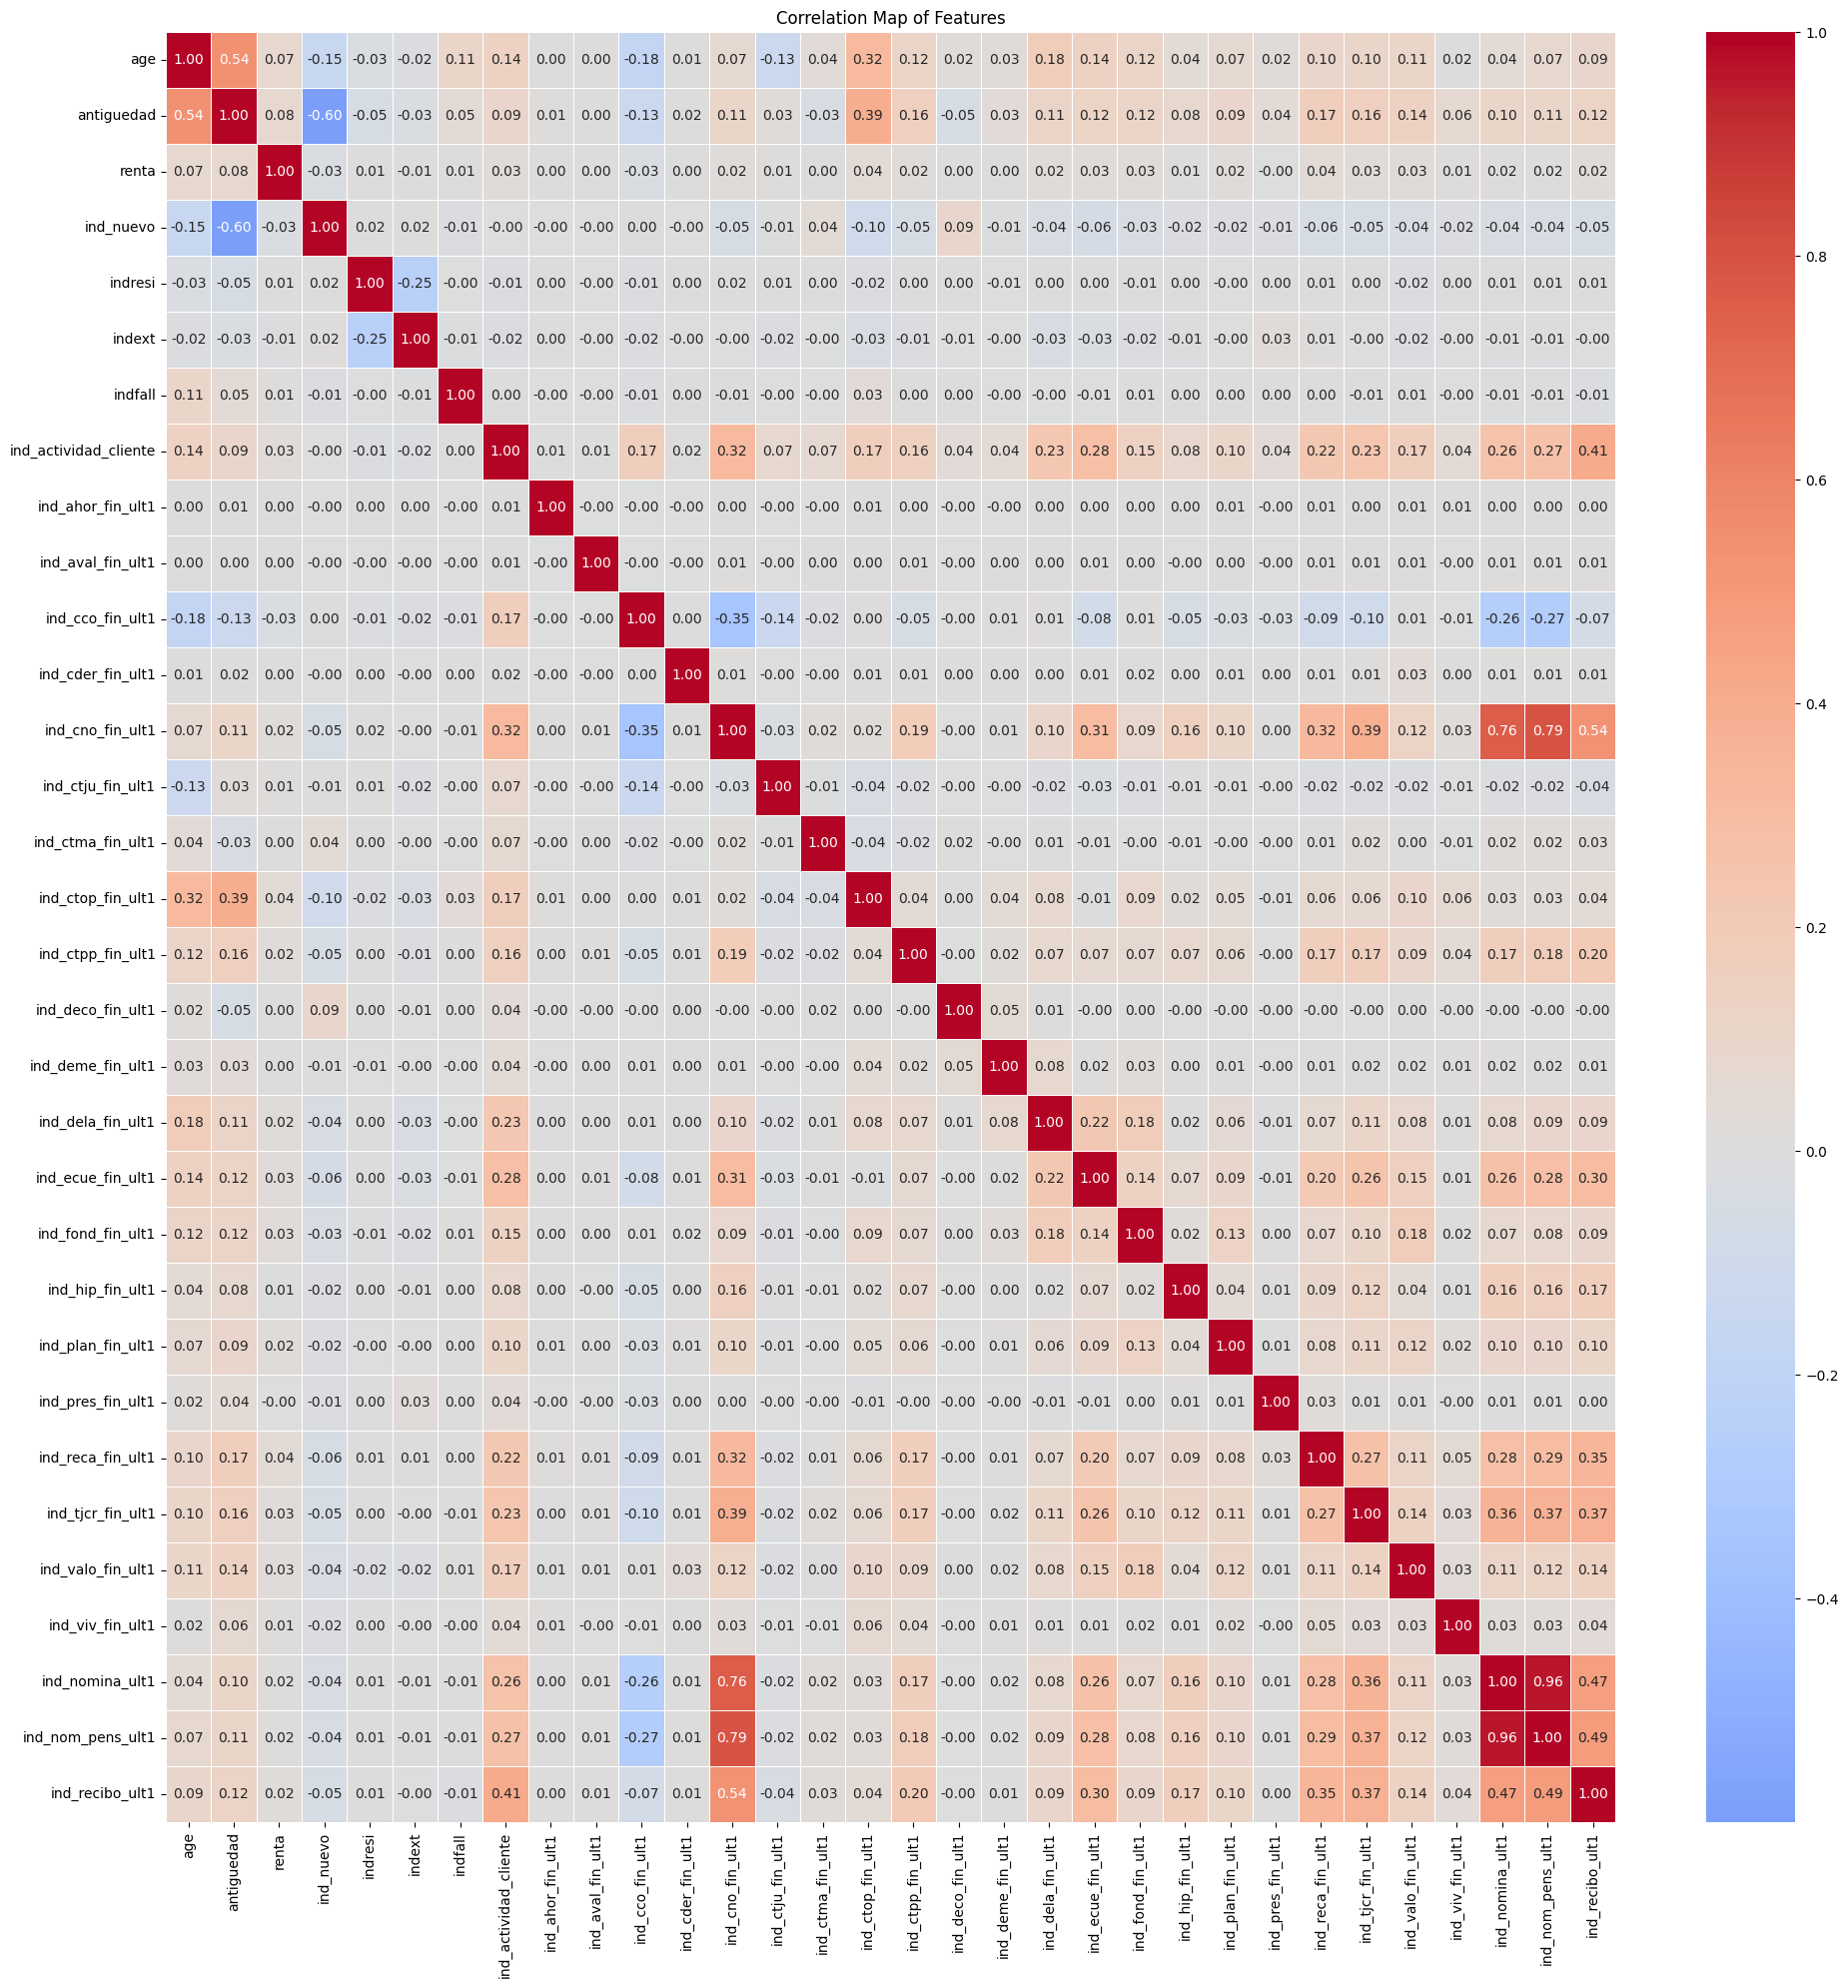


Top 10 strongest correlations:


feature_1,feature_2,correlation
str,str,f64
"""ind_nomina_ult1""","""ind_nom_pens_ult1""",0.957215
"""ind_cno_fin_ult1""","""ind_nom_pens_ult1""",0.790194
"""ind_cno_fin_ult1""","""ind_nomina_ult1""",0.75802
"""antiguedad""","""ind_nuevo""",-0.599899
"""age""","""antiguedad""",0.541678
"""ind_cno_fin_ult1""","""ind_recibo_ult1""",0.535712
"""ind_nom_pens_ult1""","""ind_recibo_ult1""",0.490969
"""ind_nomina_ult1""","""ind_recibo_ult1""",0.471215
"""ind_actividad_cliente""","""ind_recibo_ult1""",0.412226


(shape: (32, 32)
 ┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
 │ age       ┆ antigueda ┆ renta     ┆ ind_nuevo ┆ … ┆ ind_viv_f ┆ ind_nomin ┆ ind_nom_p ┆ ind_reci │
 │ ---       ┆ d         ┆ ---       ┆ ---       ┆   ┆ in_ult1   ┆ a_ult1    ┆ ens_ult1  ┆ bo_ult1  │
 │ f64       ┆ ---       ┆ f64       ┆ f64       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---      │
 │           ┆ f64       ┆           ┆           ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64      │
 ╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
 │ 1.0       ┆ 0.541678  ┆ 0.069566  ┆ -0.154058 ┆ … ┆ 0.017388  ┆ 0.043358  ┆ 0.071819  ┆ 0.088394 │
 │ 0.541678  ┆ 1.0       ┆ 0.075175  ┆ -0.599899 ┆ … ┆ 0.063469  ┆ 0.101253  ┆ 0.109918  ┆ 0.122339 │
 │ 0.069566  ┆ 0.075175  ┆ 1.0       ┆ -0.025886 ┆ … ┆ 0.010932  ┆ 0.016486  ┆ 0.018801  ┆ 0.022855 │
 │ -0.154058 ┆ -0.599899 ┆ -0.025886 ┆ 1.0       ┆ … ┆ -0.015612 

In [14]:
# Plot correlation heatmap
plot_correlation_heatmap(
    df_preprocessed, 
    RESULTS_DIR
)

In [15]:
# Clean up
del df_preprocessed
gc.collect()

66759

#### Preprocessed Dataset EDA Summary

Main findings:
- Raw data issues were fixed during data preprocessing step;
- Remaining missing values of antiguedad, indrel_1mes, tiprel_1mes, canal_entrada, cod_prov, nomprov, segmento features are not critical for following CatBoost modeling as CatBoost treats nulls as special category/value, avoiding possible imputting bias.
- Extreme class imbalance confirmed (product adoption rates range from 65.5% (checking accounts, ind_cco_fin_ult1) down to 0.002% (guarantees, ind_aval_fin_ult1));
- Few truly new customers (ind_nuevo mostly 0);
- Strong product correlations - strong co-purchase patterns exist within payroll account, payroll, pension account, direct debit (these fatures even highly correlated cannot be dropped as would be used for target creation, although that behaviour would be captured by engineering of interaction features);
- Moderate correlations between antiguedad and ind_nuevo (client tenure and indecator of a new client), age and antiguedad (older clients have longer tenure), ind_actividad_cliente and ind_recibo_ult1 (active clients have direct debit) (that are logical, no need to drop as correlations are not critical for following CatBoost modelling).


Things to be done:
- Engineer features (correlation-based features, log features);
- Create targets;
- Use per-product optimization in order to deal with extreme class imbalance.

ML task:

The core task is multi-label classification to predict which of 24 bank products each customer will newly acquire next month. So the dataframe should be enriched by 24 binary targets (one for each product) that are 1 if the product hadn't been acquired by a customer in the previous month, but has been in the current month, 0 otherwise.

### Feature Engineering

In [16]:
df_preprocessed = engineer_features(DATA_DIR, RESULTS_DIR, PREPROCESSED_DATA_FILE, 'data_preprocessed_feature_engineered_summary.parquet')

[2026-01-05 21:08:04,800] [INFO] Starting feature engineering pipeline
[2026-01-05 21:08:05,496] [INFO] Loaded preprocessed data from: ./data/data_preprocessed.parquet
[2026-01-05 21:08:18,683] [INFO] Created targets for new products: ['target_ahor_fin', 'target_aval_fin', 'target_cco_fin', 'target_cder_fin', 'target_cno_fin', 'target_ctju_fin', 'target_ctma_fin', 'target_ctop_fin', 'target_ctpp_fin', 'target_deco_fin', 'target_deme_fin', 'target_dela_fin', 'target_ecue_fin', 'target_fond_fin', 'target_hip_fin', 'target_plan_fin', 'target_pres_fin', 'target_reca_fin', 'target_tjcr_fin', 'target_valo_fin', 'target_viv_fin', 'target_nomina', 'target_nom_pens', 'target_recibo']
[2026-01-05 21:08:18,687] [INFO] Adding 3m lags...
[2026-01-05 21:08:27,500] [INFO] Added 3m lags for 10 products
[2026-01-05 21:08:27,502] [INFO] Adding 6m lags...
[2026-01-05 21:08:36,274] [INFO] Added 6m lags for 10 products
[2026-01-05 21:08:43,251] [INFO] Added recently acquired features for 10 products
[2026-

In [17]:
# Preprocessed and feature engineered data overview
data_summary(
    df_preprocessed, 
    'preprocessed and feature engineered data',
    RESULTS_DIR
)


===== PREPROCESSED AND FEATURE ENGINEERED DATA =====

Sample rows:


fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,indresi,indext,canal_entrada,indfall,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,…,ind_ahor_fin_ult1_lag3,ind_aval_fin_ult1_lag3,ind_cco_fin_ult1_lag3,ind_cder_fin_ult1_lag3,ind_cno_fin_ult1_lag3,ind_ctju_fin_ult1_lag3,ind_ctma_fin_ult1_lag3,ind_ctop_fin_ult1_lag3,ind_ctpp_fin_ult1_lag3,ind_deco_fin_ult1_lag3,n_products_lag3,ind_ahor_fin_ult1_lag6,ind_aval_fin_ult1_lag6,ind_cco_fin_ult1_lag6,ind_cder_fin_ult1_lag6,ind_cno_fin_ult1_lag6,ind_ctju_fin_ult1_lag6,ind_ctma_fin_ult1_lag6,ind_ctop_fin_ult1_lag6,ind_ctpp_fin_ult1_lag6,ind_deco_fin_ult1_lag6,n_products_lag6,ind_ahor_fin_ult1_acquired_recently,ind_aval_fin_ult1_acquired_recently,ind_cco_fin_ult1_acquired_recently,ind_cder_fin_ult1_acquired_recently,ind_cno_fin_ult1_acquired_recently,ind_ctju_fin_ult1_acquired_recently,ind_ctma_fin_ult1_acquired_recently,ind_ctop_fin_ult1_acquired_recently,ind_ctpp_fin_ult1_acquired_recently,ind_deco_fin_ult1_acquired_recently,ind_nomina_ult1_ind_nom_pens_ult1_interaction,ind_cno_fin_ult1_ind_nom_pens_ult1_interaction,ind_cno_fin_ult1_ind_nomina_ult1_interaction,ind_cno_fin_ult1_ind_recibo_ult1_interaction,ind_nomina_ult1_ind_recibo_ult1_interaction
date,str,cat,cat,cat,u8,date,bool,f64,cat,cat,cat,bool,bool,cat,bool,cat,cat,bool,f32,cat,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,…,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,u32,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,u32,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8,i8
2015-01-28,""" 15889""","""3""","""ES""","""1""",56,1995-01-16,false,5.505332,"""1""","""1""","""1""",true,false,"""KAT""",false,"""28""","""MADRID""",true,326124.90625,"""1""",false,false,true,false,false,false,false,false,true,false,false,false,false,false,false,false,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0,0,null,0,0,0,0,0,null,0,0,0,0,0,0
2015-02-28,""" 15889""","""3""","""ES""","""1""",56,1995-01-16,false,5.505332,"""1""","""1""","""1""",true,false,"""KAT""",false,"""28""","""MADRID""",true,326124.90625,"""1""",false,false,true,false,false,false,false,false,true,false,false,false,false,false,false,false,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-03-28,""" 15889""","""3""","""ES""","""1""",56,1995-01-16,false,5.505332,"""1""","""1""","""1""",true,false,"""KAT""",false,"""28""","""MADRID""",true,326124.90625,"""1""",false,false,true,false,false,false,false,false,true,false,false,false,false,false,false,false,…,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-04-28,""" 15889""","""3""","""ES""","""1""",56,1995-01-16,false,5.505332,"""1""","""1""","""1""",true,false,"""KAT""",false,"""28""","""MADRID""",true,326124.90625,"""1""",false,false,true,false,false,false,false,false,true,false,false,false,false,false,false,false,…,false,false,true,false,false,false,false,false,true,false,2,null,null,null,null,null,null,null,null,null,null,null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2015-05-28,""" 15889""","""3""","""ES""","""1""",56,1995-01-16,false,5.505332,"""1""","""1""","""1""",true,false,"""KAT""",false,"""28""","""MADRID""",true,326124.90625,"""1""",false,false,true,false,false,false,false,false,true,false,false,false,false,false,false,false,…,false,false,true,false,false,false,false,false,true,false,2,null,null,null,null,null,null,null,null,null,null,null,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0



Shape: 12687840 rows x 106 columns

Data types:
fecha_dato: Date
ncodpers: String
ind_empleado: Categorical
pais_residencia: Categorical
sexo: Categorical
age: UInt8
fecha_alta: Date
ind_nuevo: Boolean
antiguedad: Float64
indrel: Categorical
indrel_1mes: Categorical
tiprel_1mes: Categorical
indresi: Boolean
indext: Boolean
canal_entrada: Categorical
indfall: Boolean
cod_prov: Categorical
nomprov: Categorical
ind_actividad_cliente: Boolean
renta: Float32
segmento: Categorical
ind_ahor_fin_ult1: Boolean
ind_aval_fin_ult1: Boolean
ind_cco_fin_ult1: Boolean
ind_cder_fin_ult1: Boolean
ind_cno_fin_ult1: Boolean
ind_ctju_fin_ult1: Boolean
ind_ctma_fin_ult1: Boolean
ind_ctop_fin_ult1: Boolean
ind_ctpp_fin_ult1: Boolean
ind_deco_fin_ult1: Boolean
ind_deme_fin_ult1: Boolean
ind_dela_fin_ult1: Boolean
ind_ecue_fin_ult1: Boolean
ind_fond_fin_ult1: Boolean
ind_hip_fin_ult1: Boolean
ind_plan_fin_ult1: Boolean
ind_pres_fin_ult1: Boolean
ind_reca_fin_ult1: Boolean
ind_tjcr_fin_ult1: Boolean
ind_valo_

statistic,age,antiguedad,renta,n_products_lag3,n_products_lag6,ind_ahor_fin_ult1_acquired_recently,ind_aval_fin_ult1_acquired_recently,ind_cco_fin_ult1_acquired_recently,ind_cder_fin_ult1_acquired_recently,ind_cno_fin_ult1_acquired_recently,ind_ctju_fin_ult1_acquired_recently,ind_ctma_fin_ult1_acquired_recently,ind_ctop_fin_ult1_acquired_recently,ind_ctpp_fin_ult1_acquired_recently,ind_deco_fin_ult1_acquired_recently,ind_nomina_ult1_ind_nom_pens_ult1_interaction,ind_cno_fin_ult1_ind_nom_pens_ult1_interaction,ind_cno_fin_ult1_ind_nomina_ult1_interaction,ind_cno_fin_ult1_ind_recibo_ult1_interaction,ind_nomina_ult1_ind_recibo_ult1_interaction
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",1.268784e7,1.2687805e7,1.268784e7,9.878203e6,7.134701e6,1.2687752e7,1.2687821e7,1.2110097e7,1.2687534e7,1.2628275e7,1.2679437e7,1.2677039e7,1.2581786e7,1.2651757e7,1.268433e7,1.268784e7,1.268784e7,1.268784e7,1.268784e7,1.268784e7
"""null_count""",0.0,35.0,0.0,2.809637e6,5.553139e6,88.0,19.0,577743.0,306.0,59565.0,8403.0,10801.0,106054.0,36083.0,3510.0,0.0,0.0,0.0,0.0,0.0
"""mean""",40.194959,3.88755,127409.53125,0.965334,1.007881,7.8816e-8,3.1526e-7,0.005435,0.00001,0.002757,0.000035,0.000505,0.00029,0.000181,0.000239,0.004695,0.028806,0.032738,0.090804,0.097487
"""std""",16.983857,1.169361,207106.671875,0.612145,0.597323,0.000281,0.000561,0.073523,0.003201,0.052438,0.005951,0.022475,0.01703,0.013447,0.015451,0.068357,0.16726,0.177951,0.28733,0.29662
"""min""",18.0,0.0,1202.72998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""25%""",24.0,3.178054,70974.328125,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""50%""",39.0,3.931826,99680.070312,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""75%""",50.0,4.912655,140228.578125,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""max""",90.0,5.545177,2.8894396e7,6.0,6.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0



Unique customer id values: 944896
Unique values:

Column: fecha_dato


fecha_dato
struct[2]
"{2016-04-28,928269}"
"{2015-08-28,843196}"
"{2015-12-28,912016}"
"{2015-10-28,892246}"
"{2015-09-28,865435}"
…
"{2015-05-28,628334}"
"{2015-01-28,618442}"
"{2016-01-28,916264}"



Column: ind_empleado


ind_empleado
struct[2]
"{""1"",2344}"
"{""2"",3347}"
"{""4"",12679762}"
"{""5"",16}"
"{""3"",2371}"



Column: pais_residencia


pais_residencia
struct[2]
"{""IS"",16}"
"{""US"",3421}"
"{""CZ"",96}"
"{""SL"",16}"
"{""FR"",4849}"
…
"{""CD"",16}"
"{""RS"",32}"
"{""OM"",20}"



Column: sexo


sexo
struct[2]
"{""1"",6918529}"
"{""0"",5769311}"



Column: fecha_alta


fecha_alta
struct[2]
"{2002-11-14,1257}"
"{1995-10-27,1729}"
"{2004-10-27,1408}"
"{1995-06-20,284}"
"{2009-01-08,1199}"
…
"{2004-12-14,1466}"
"{2007-07-18,1717}"
"{2005-10-13,1422}"



Column: ind_nuevo


ind_nuevo
struct[2]
"{false,11911114}"
"{true,776726}"



Column: indrel


indrel
struct[2]
"{""1"",12664918}"
"{""0"",22922}"



Column: indrel_1mes


indrel_1mes
struct[2]
"{""5"",796}"
"{""4"",281}"
"{""2"",1194}"
"{null,118037}"
"{""3"",4017}"
"{""1"",12563515}"



Column: tiprel_1mes


tiprel_1mes
struct[2]
"{""2"",6770406}"
"{""5"",4}"
"{""3"",4298}"
"{null,118037}"
"{""1"",5794303}"
"{""4"",792}"



Column: indresi


indresi
struct[2]
"{false,61856}"
"{true,12625984}"



Column: indext


indext
struct[2]
"{false,12089367}"
"{true,598473}"



Column: canal_entrada


canal_entrada
struct[2]
"{""KFD"",41507}"
"{""KFK"",3642}"
"{""KDR"",7512}"
"{""KAL"",7057}"
"{""KBQ"",3912}"
…
"{""KBB"",1210}"
"{""KDL"",10}"
"{""KHC"",15287}"



Column: indfall


indfall
struct[2]
"{false,12655447}"
"{true,32393}"



Column: cod_prov


cod_prov
struct[2]
"{""17"",84224}"
"{""25"",73618}"
"{""47"",222213}"
"{""24"",77269}"
"{""16"",53517}"
…
"{""7"",115790}"
"{""45"",170375}"
"{""32"",78394}"



Column: nomprov


nomprov
struct[2]
"{""ALICANTE"",291185}"
"{""LERIDA"",73618}"
"{""CANTABRIA"",144855}"
"{""SEVILLA"",564567}"
"{""BADAJOZ"",180046}"
…
"{""ALMERIA"",55974}"
"{""BALEARS, ILLES"",115790}"
"{""SANTA CRUZ DE TENERIFE"",65849}"



Column: ind_actividad_cliente


ind_actividad_cliente
struct[2]
"{true,5839252}"
"{false,6848588}"



Column: segmento


segmento
struct[2]
"{""2"",7417444}"
"{null,154528}"
"{""1"",526722}"
"{""3"",4589146}"



Column: ind_ahor_fin_ult1


ind_ahor_fin_ult1
struct[2]
"{true,1318}"
"{false,12686522}"



Column: ind_aval_fin_ult1


ind_aval_fin_ult1
struct[2]
"{false,12687540}"
"{true,300}"



Column: ind_cco_fin_ult1


ind_cco_fin_ult1
struct[2]
"{false,4311325}"
"{true,8376515}"



Column: ind_cder_fin_ult1


ind_cder_fin_ult1
struct[2]
"{false,12682784}"
"{true,5056}"



Column: ind_cno_fin_ult1


ind_cno_fin_ult1
struct[2]
"{false,11657885}"
"{true,1029955}"



Column: ind_ctju_fin_ult1


ind_ctju_fin_ult1
struct[2]
"{false,12566373}"
"{true,121467}"



Column: ind_ctma_fin_ult1


ind_ctma_fin_ult1
struct[2]
"{false,12563683}"
"{true,124157}"



Column: ind_ctop_fin_ult1


ind_ctop_fin_ult1
struct[2]
"{false,11029046}"
"{true,1658794}"



Column: ind_ctpp_fin_ult1


ind_ctpp_fin_ult1
struct[2]
"{true,557384}"
"{false,12130456}"



Column: ind_deco_fin_ult1


ind_deco_fin_ult1
struct[2]
"{true,23516}"
"{false,12664324}"



Column: ind_deme_fin_ult1


ind_deme_fin_ult1
struct[2]
"{false,12666198}"
"{true,21642}"



Column: ind_dela_fin_ult1


ind_dela_fin_ult1
struct[2]
"{true,554999}"
"{false,12132841}"



Column: ind_ecue_fin_ult1


ind_ecue_fin_ult1
struct[2]
"{true,1052174}"
"{false,11635666}"



Column: ind_fond_fin_ult1


ind_fond_fin_ult1
struct[2]
"{true,237469}"
"{false,12450371}"



Column: ind_hip_fin_ult1


ind_hip_fin_ult1
struct[2]
"{false,12612308}"
"{true,75532}"



Column: ind_plan_fin_ult1


ind_plan_fin_ult1
struct[2]
"{false,12570101}"
"{true,117739}"



Column: ind_pres_fin_ult1


ind_pres_fin_ult1
struct[2]
"{true,32532}"
"{false,12655308}"



Column: ind_reca_fin_ult1


ind_reca_fin_ult1
struct[2]
"{true,661199}"
"{false,12026641}"



Column: ind_tjcr_fin_ult1


ind_tjcr_fin_ult1
struct[2]
"{false,12117101}"
"{true,570739}"



Column: ind_valo_fin_ult1


ind_valo_fin_ult1
struct[2]
"{false,12359942}"
"{true,327898}"



Column: ind_viv_fin_ult1


ind_viv_fin_ult1
struct[2]
"{false,12638315}"
"{true,49525}"



Column: ind_nomina_ult1


ind_nomina_ult1
struct[2]
"{false,11990393}"
"{true,697447}"



Column: ind_nom_pens_ult1


ind_nom_pens_ult1
struct[2]
"{true,757012}"
"{false,11930828}"



Column: ind_recibo_ult1


ind_recibo_ult1
struct[2]
"{false,11056102}"
"{true,1631738}"



Column: target_ahor_fin


target_ahor_fin
struct[2]
"{null,18161}"
"{false,12669677}"
"{true,2}"



Column: target_aval_fin


target_aval_fin
struct[2]
"{true,4}"
"{null,18161}"
"{false,12669675}"



Column: target_cco_fin


target_cco_fin
struct[2]
"{null,17965}"
"{true,69693}"
"{false,12600182}"



Column: target_cder_fin


target_cder_fin
struct[2]
"{true,135}"
"{false,12669544}"
"{null,18161}"



Column: target_cno_fin


target_cno_fin
struct[2]
"{null,18155}"
"{false,12632517}"
"{true,37168}"



Column: target_ctju_fin


target_ctju_fin
struct[2]
"{false,12669196}"
"{null,18155}"
"{true,489}"



Column: target_ctma_fin


target_ctma_fin
struct[2]
"{false,12662746}"
"{null,18161}"
"{true,6933}"



Column: target_ctop_fin


target_ctop_fin
struct[2]
"{false,12665817}"
"{null,18147}"
"{true,3876}"



Column: target_ctpp_fin


target_ctpp_fin
struct[2]
"{null,18158}"
"{false,12667263}"
"{true,2419}"



Column: target_deco_fin


target_deco_fin
struct[2]
"{null,18160}"
"{false,12666651}"
"{true,3029}"



Column: target_deme_fin


target_deme_fin
struct[2]
"{null,18161}"
"{true,250}"
"{false,12669429}"



Column: target_dela_fin


target_dela_fin
struct[2]
"{null,18160}"
"{true,12701}"
"{false,12656979}"



Column: target_ecue_fin


target_ecue_fin
struct[2]
"{null,18139}"
"{false,12643446}"
"{true,26255}"



Column: target_fond_fin


target_fond_fin
struct[2]
"{null,18160}"
"{true,3698}"
"{false,12665982}"



Column: target_hip_fin


target_hip_fin
struct[2]
"{null,18160}"
"{false,12669605}"
"{true,75}"



Column: target_plan_fin


target_plan_fin
struct[2]
"{true,618}"
"{false,12669061}"
"{null,18161}"



Column: target_pres_fin


target_pres_fin
struct[2]
"{true,147}"
"{null,18158}"
"{false,12669535}"



Column: target_reca_fin


target_reca_fin
struct[2]
"{null,17806}"
"{false,12660811}"
"{true,9223}"



Column: target_tjcr_fin


target_tjcr_fin
struct[2]
"{null,18157}"
"{false,12600384}"
"{true,69299}"



Column: target_valo_fin


target_valo_fin
struct[2]
"{null,18161}"
"{true,4848}"
"{false,12664831}"



Column: target_viv_fin


target_viv_fin
struct[2]
"{true,70}"
"{null,18160}"
"{false,12669610}"



Column: target_nomina


target_nomina
struct[2]
"{null,18109}"
"{false,12595956}"
"{true,73775}"



Column: target_nom_pens


target_nom_pens
struct[2]
"{null,18100}"
"{false,12585000}"
"{true,84740}"



Column: target_recibo


target_recibo
struct[2]
"{false,12517018}"
"{null,17747}"
"{true,153075}"



Column: ind_ahor_fin_ult1_lag3


ind_ahor_fin_ult1_lag3
struct[2]
"{false,9877123}"
"{true,1080}"
"{null,2809637}"



Column: ind_aval_fin_ult1_lag3


ind_aval_fin_ult1_lag3
struct[2]
"{false,9877951}"
"{null,2809637}"
"{true,252}"



Column: ind_cco_fin_ult1_lag3


ind_cco_fin_ult1_lag3
struct[2]
"{false,3194856}"
"{true,6683347}"
"{null,2809637}"



Column: ind_cder_fin_ult1_lag3


ind_cder_fin_ult1_lag3
struct[2]
"{true,4094}"
"{false,9874109}"
"{null,2809637}"



Column: ind_cno_fin_ult1_lag3


ind_cno_fin_ult1_lag3
struct[2]
"{null,2809637}"
"{false,9059486}"
"{true,818717}"



Column: ind_ctju_fin_ult1_lag3


ind_ctju_fin_ult1_lag3
struct[2]
"{false,9779751}"
"{true,98452}"
"{null,2809637}"



Column: ind_ctma_fin_ult1_lag3


ind_ctma_fin_ult1_lag3
struct[2]
"{false,9780137}"
"{true,98066}"
"{null,2809637}"



Column: ind_ctop_fin_ult1_lag3


ind_ctop_fin_ult1_lag3
struct[2]
"{null,2809637}"
"{true,1353512}"
"{false,8524691}"



Column: ind_ctpp_fin_ult1_lag3


ind_ctpp_fin_ult1_lag3
struct[2]
"{null,2809637}"
"{true,456082}"
"{false,9422121}"



Column: ind_deco_fin_ult1_lag3


ind_deco_fin_ult1_lag3
struct[2]
"{null,2809637}"
"{false,9856037}"
"{true,22166}"



Column: ind_ahor_fin_ult1_lag6


ind_ahor_fin_ult1_lag6
struct[2]
"{false,7133866}"
"{null,5553139}"
"{true,835}"



Column: ind_aval_fin_ult1_lag6


ind_aval_fin_ult1_lag6
struct[2]
"{true,198}"
"{false,7134503}"
"{null,5553139}"



Column: ind_cco_fin_ult1_lag6


ind_cco_fin_ult1_lag6
struct[2]
"{false,2129470}"
"{true,5005231}"
"{null,5553139}"



Column: ind_cder_fin_ult1_lag6


ind_cder_fin_ult1_lag6
struct[2]
"{false,7131571}"
"{null,5553139}"
"{true,3130}"



Column: ind_cno_fin_ult1_lag6


ind_cno_fin_ult1_lag6
struct[2]
"{null,5553139}"
"{false,6517790}"
"{true,616911}"



Column: ind_ctju_fin_ult1_lag6


ind_ctju_fin_ult1_lag6
struct[2]
"{true,75461}"
"{null,5553139}"
"{false,7059240}"



Column: ind_ctma_fin_ult1_lag6


ind_ctma_fin_ult1_lag6
struct[2]
"{null,5553139}"
"{false,7061427}"
"{true,73274}"



Column: ind_ctop_fin_ult1_lag6


ind_ctop_fin_ult1_lag6
struct[2]
"{null,5553139}"
"{false,6090231}"
"{true,1044470}"



Column: ind_ctpp_fin_ult1_lag6


ind_ctpp_fin_ult1_lag6
struct[2]
"{true,352879}"
"{null,5553139}"
"{false,6781822}"



Column: ind_deco_fin_ult1_lag6


ind_deco_fin_ult1_lag6
struct[2]
"{null,5553139}"
"{true,18544}"
"{false,7116157}"



Missing values:


fecha_dato,ncodpers,ind_empleado,pais_residencia,sexo,age,fecha_alta,ind_nuevo,antiguedad,indrel,indrel_1mes,tiprel_1mes,indresi,indext,canal_entrada,indfall,cod_prov,nomprov,ind_actividad_cliente,renta,segmento,ind_ahor_fin_ult1,ind_aval_fin_ult1,ind_cco_fin_ult1,ind_cder_fin_ult1,ind_cno_fin_ult1,ind_ctju_fin_ult1,ind_ctma_fin_ult1,ind_ctop_fin_ult1,ind_ctpp_fin_ult1,ind_deco_fin_ult1,ind_deme_fin_ult1,ind_dela_fin_ult1,ind_ecue_fin_ult1,ind_fond_fin_ult1,ind_hip_fin_ult1,ind_plan_fin_ult1,…,ind_ahor_fin_ult1_lag3,ind_aval_fin_ult1_lag3,ind_cco_fin_ult1_lag3,ind_cder_fin_ult1_lag3,ind_cno_fin_ult1_lag3,ind_ctju_fin_ult1_lag3,ind_ctma_fin_ult1_lag3,ind_ctop_fin_ult1_lag3,ind_ctpp_fin_ult1_lag3,ind_deco_fin_ult1_lag3,n_products_lag3,ind_ahor_fin_ult1_lag6,ind_aval_fin_ult1_lag6,ind_cco_fin_ult1_lag6,ind_cder_fin_ult1_lag6,ind_cno_fin_ult1_lag6,ind_ctju_fin_ult1_lag6,ind_ctma_fin_ult1_lag6,ind_ctop_fin_ult1_lag6,ind_ctpp_fin_ult1_lag6,ind_deco_fin_ult1_lag6,n_products_lag6,ind_ahor_fin_ult1_acquired_recently,ind_aval_fin_ult1_acquired_recently,ind_cco_fin_ult1_acquired_recently,ind_cder_fin_ult1_acquired_recently,ind_cno_fin_ult1_acquired_recently,ind_ctju_fin_ult1_acquired_recently,ind_ctma_fin_ult1_acquired_recently,ind_ctop_fin_ult1_acquired_recently,ind_ctpp_fin_ult1_acquired_recently,ind_deco_fin_ult1_acquired_recently,ind_nomina_ult1_ind_nom_pens_ult1_interaction,ind_cno_fin_ult1_ind_nom_pens_ult1_interaction,ind_cno_fin_ult1_ind_nomina_ult1_interaction,ind_cno_fin_ult1_ind_recibo_ult1_interaction,ind_nomina_ult1_ind_recibo_ult1_interaction
u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
0,0,0,0,0,0,0,0,35,0,118037,118037,0,0,151627,0,61865,61865,0,0,154528,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,…,2809637,2809637,2809637,2809637,2809637,2809637,2809637,2809637,2809637,2809637,2809637,5553139,5553139,5553139,5553139,5553139,5553139,5553139,5553139,5553139,5553139,5553139,88,19,577743,306,59565,8403,10801,106054,36083,3510,0,0,0,0,0


Selected 20 numeric and 73 boolean columns
Columns with null values: ['antiguedad', 'n_products_lag3', 'n_products_lag6', 'ind_ahor_fin_ult1_acquired_recently', 'ind_aval_fin_ult1_acquired_recently', 'ind_cco_fin_ult1_acquired_recently', 'ind_cder_fin_ult1_acquired_recently', 'ind_cno_fin_ult1_acquired_recently', 'ind_ctju_fin_ult1_acquired_recently', 'ind_ctma_fin_ult1_acquired_recently', 'ind_ctop_fin_ult1_acquired_recently', 'ind_ctpp_fin_ult1_acquired_recently', 'ind_deco_fin_ult1_acquired_recently', 'target_ahor_fin', 'target_aval_fin', 'target_cco_fin', 'target_cder_fin', 'target_cno_fin', 'target_ctju_fin', 'target_ctma_fin', 'target_ctop_fin', 'target_ctpp_fin', 'target_deco_fin', 'target_deme_fin', 'target_dela_fin', 'target_ecue_fin', 'target_fond_fin', 'target_hip_fin', 'target_plan_fin', 'target_pres_fin', 'target_reca_fin', 'target_tjcr_fin', 'target_valo_fin', 'target_viv_fin', 'target_nomina', 'target_nom_pens', 'target_recibo', 'ind_ahor_fin_ult1_lag3', 'ind_aval_fin_ul

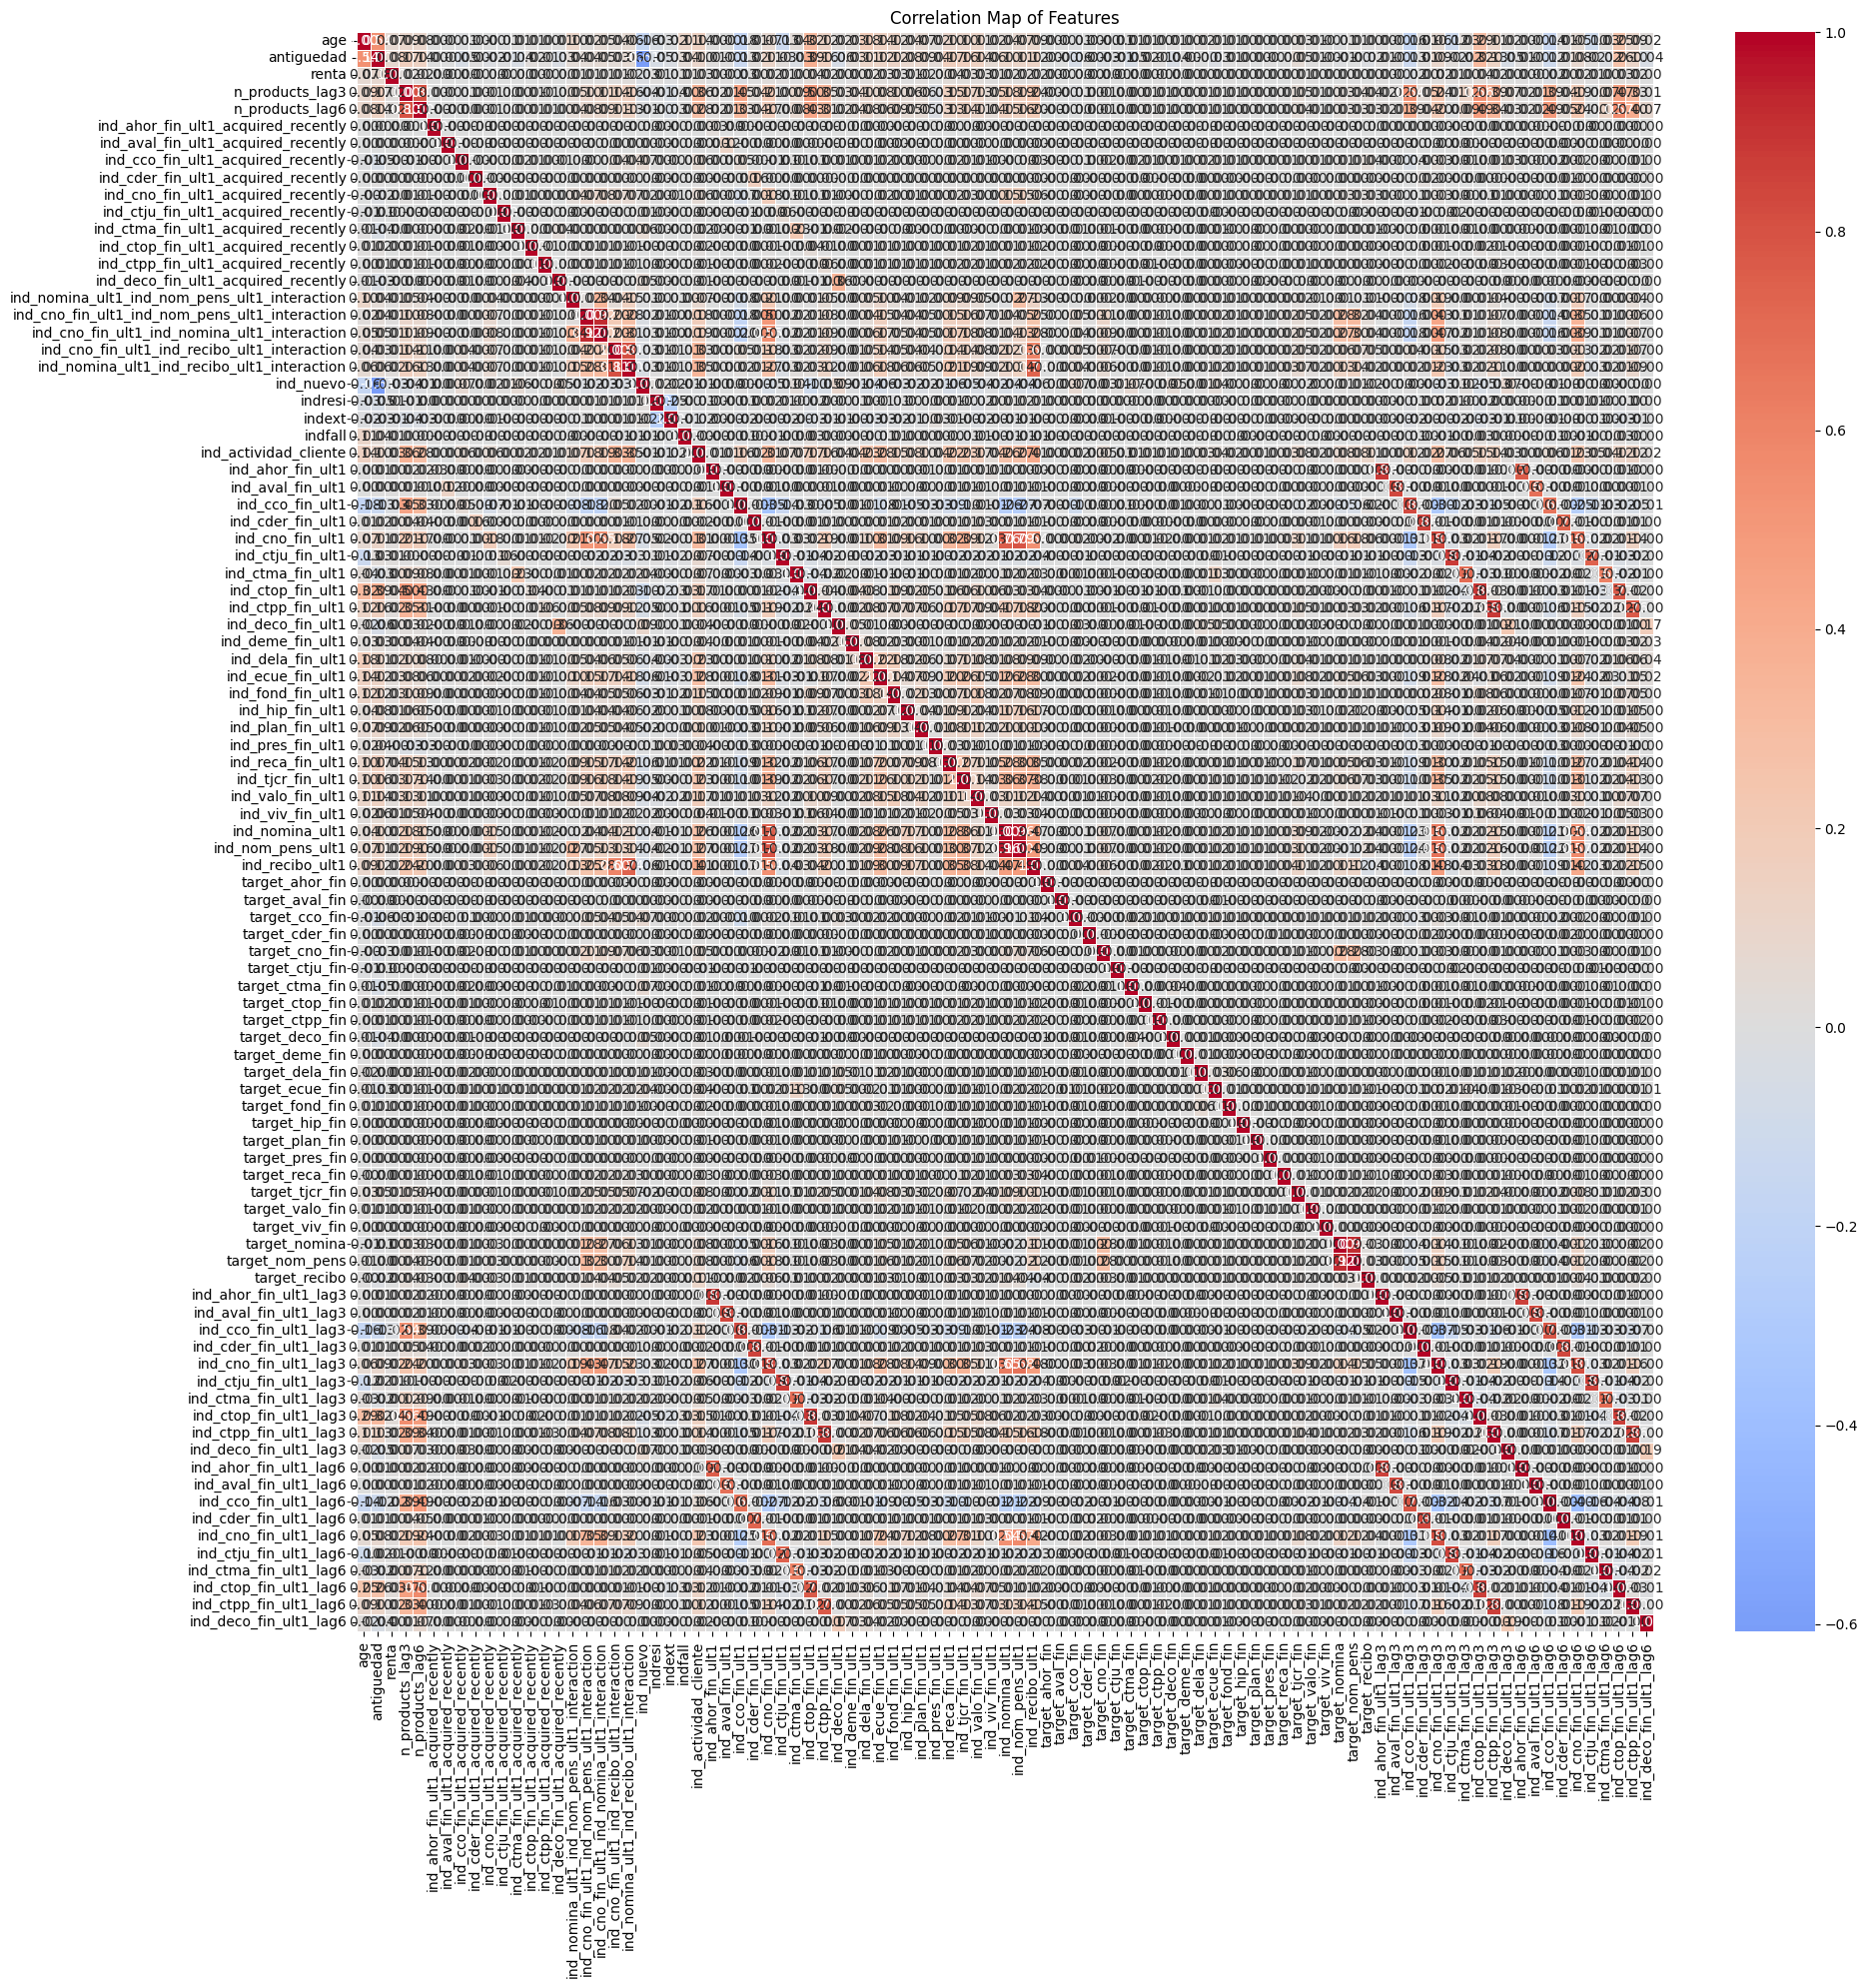


Top 10 strongest correlations:


feature_1,feature_2,correlation
str,str,f64
"""ind_nomina_ult1""","""ind_nom_pens_ult1""",0.957465
"""ind_cno_fin_ult1_ind_nom_pens_…","""ind_cno_fin_ult1_ind_nomina_ul…",0.923316
"""target_nomina""","""target_nom_pens""",0.918847
"""ind_ctop_fin_ult1""","""ind_ctop_fin_ult1_lag3""",0.887966
"""ind_ctpp_fin_ult1""","""ind_ctpp_fin_ult1_lag3""",0.883713
"""ind_ahor_fin_ult1""","""ind_ahor_fin_ult1_lag3""",0.880911
"""ind_ctju_fin_ult1""","""ind_ctju_fin_ult1_lag3""",0.874951
"""ind_ctop_fin_ult1_lag3""","""ind_ctop_fin_ult1_lag6""",0.8628
"""ind_ctpp_fin_ult1_lag3""","""ind_ctpp_fin_ult1_lag6""",0.859897


(shape: (93, 93)
 ┌───────────┬───────────┬──────────┬───────────┬───┬───────────┬───────────┬───────────┬───────────┐
 │ age       ┆ antigueda ┆ renta    ┆ n_product ┆ … ┆ ind_ctma_ ┆ ind_ctop_ ┆ ind_ctpp_ ┆ ind_deco_ │
 │ ---       ┆ d         ┆ ---      ┆ s_lag3    ┆   ┆ fin_ult1_ ┆ fin_ult1_ ┆ fin_ult1_ ┆ fin_ult1_ │
 │ f64       ┆ ---       ┆ f64      ┆ ---       ┆   ┆ lag6      ┆ lag6      ┆ lag6      ┆ lag6      │
 │           ┆ f64       ┆          ┆ f64       ┆   ┆ ---       ┆ ---       ┆ ---       ┆ ---       │
 │           ┆           ┆          ┆           ┆   ┆ f64       ┆ f64       ┆ f64       ┆ f64       │
 ╞═══════════╪═══════════╪══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪═══════════╡
 │ 1.0       ┆ 0.54319   ┆ 0.069665 ┆ 0.089631  ┆ … ┆ 0.026167  ┆ 0.24833   ┆ 0.090646  ┆ 0.016979  │
 │ 0.54319   ┆ 1.0       ┆ 0.075038 ┆ 0.166997  ┆ … ┆ -0.018222 ┆ 0.263291  ┆ 0.102611  ┆ -0.041681 │
 │ 0.069665  ┆ 0.075038  ┆ 1.0      ┆ 0.020125  ┆ … ┆ 0.002171  ┆

In [18]:
# Plot correlation heatmap
plot_correlation_heatmap(
    df_preprocessed, 
    RESULTS_DIR
)

#### Feature Engineering Step Summary

Added features:

- Targets;
Target features as 'target_nomina', 'target_nom_pens', etc.
That are 24 binary features (for each of 24 products that is 1 if the customer doesn't have the product now but will have it next month), thus identify product additions.
- Lag features;
Features as 'ind_deco_fin_ult1_lag3', 'ind_deco_fin_ult1_lag6', etc
That adds information about product holding history and customer lifecycle understanding.
- Aggregate lags;
Features as 'n_products_lag3', 'n_products_lag6'.
That adds information about  customer engagement trend.
- Recently acquired features;
Features as 'ind_aval_fin_ult1_acquired_recently', etc.
That capture actual change (customers who just started using a product), thus seems to be a highly predictive for recommendations (it's likely that a customer would add also hightly related products).
- Interaction features;
Features as 'ind_cno_fin_ult1_ind_nomina_ult1_interaction'.
That use 'one, but not the other' logic (1 if a customer has exactly one of two highly correlated products), thus identify cross-sell opportunities (in the case a customer has A but not B, so offer B).

Other features are:
- Customer profile;
Features as 'age', 'antiguedad', 'renta', 'canal_entrada', 'segmento', etc.
That add understanding of customers' demografics and custumer segments.
- Product columns.
Features as 'ind_nomina_ult1', 'ind_nom_pens_ult1, etc.
That indicate what products customers already have.

Data quality & signal assessment:

- Null targets for the last month, which is expected as no next month exists;
- No data leakage as features use current/past data, while targets are future-oriented;
- Highly imbalanced targets as product additions are rare events (most customers don't add products each month);
- Newly engineered features are internally consistent and correctly aligned in time (e.g., lags and targets computed by customer and date order), so no data leakage exist;
- Remaining missing values are largely structural or expected (e.g., no lag if there is no previous month, no recently acquired flag if product was never added), rather than data errors, and can either be left as-is for gradient boosting models;
- Some engineered features show high, but not perfect, correlation with existing variables (e.g., interactions and aggregate lags), that is logical and indicates genuine incremental information.

Thus, the engineered feature set now provides a rich, multi-angle view of each customer’s profile, behavior history, and product lifecycle, giving the model enough signal for recommendations.

### Train / Test Split

In [19]:
# Create splits
X_train, X_test, y_train, y_test = temporal_train_test_split()

# Later, reload them
X_train, X_test, y_train, y_test = load_splits()

[2026-01-05 21:10:23,435] [INFO] Starting train/test split pipeline
[2026-01-05 21:10:24,442] [INFO] Loaded data from: ./data/data_preprocessed.parquet
[2026-01-05 21:10:24,443] [INFO] Total rows: 12,687,840, Total columns: 106
[2026-01-05 21:10:24,572] [INFO] Date range: 2015-01-28 to 2016-04-28 (16 months)
[2026-01-05 21:10:24,573] [INFO] Train dates: 2015-01-28 to 2016-03-28 (15 months)
[2026-01-05 21:10:24,574] [INFO] Test dates: 2016-04-28 to 2016-04-28 (1 months)
[2026-01-05 21:10:24,947] [INFO] Train rows: 11,759,571
[2026-01-05 21:10:24,947] [INFO] Test rows: 928,269
[2026-01-05 21:10:24,952] [INFO] Number of features: 80
[2026-01-05 21:10:24,952] [INFO] Number of targets: 24
[2026-01-05 21:10:25,037] [INFO] Split done
[2026-01-05 21:10:25,037] [INFO]   - X_train rows: 11,759,571
[2026-01-05 21:10:25,037] [INFO]   - X_test rows: 928,269
[2026-01-05 21:10:25,037] [INFO]   - y_train rows: 11,759,571
[2026-01-05 21:10:25,043] [INFO]   - y_test rows: 928,269
[2026-01-05 21:10:26,59